# Analyzing New York City High School Data

In this data cleaning project, we'll take a look at whether standardized tests like the SAT are unfair to certain demographics by investigating the correlations between SAT scores in New York City––NYC––high schools.

The [SAT](https://en.wikipedia.org/wiki/SAT)––Scholastic Aptitude Test––is the most prevalent standardized exam that U.S. high school students take before applying for college, as it is frequently used by universities to assess college admissions. The test comprises three sections, each with a possible 800 points for a combined 2,400 possible points. Scoring well can be very important for students competing to get into top-tier universities, but the average scores are also often used to rank each high school and measure the overall school district quality.

For our analysis, we'll be using several datasets containing demographic information and test scores for New York Ciry high schools. In the first part of this project, we'll have to clean up and combine our datasets. Here are links to the datasets we will be using:

* [SAT Scores by School](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4) - SAT scores for each high school
* [School Attendance](https://data.cityofnewyork.us/Education/School-Attendance-and-Enrollment-Statistics-by-Dis/7z8d-msnt) - Attendance data for each school
* [Class Size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school
* [AP Test Results](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e) - Advanced Placement (AP) exam results for each high school
* [Graduation Outcomes](https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a) - Percentage of students who graduated
* [Demographics](https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j) - Demographic information for each school
* [All Schools & D75 Survey](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8) - Surveys of parents, teachers, and students at each school

There are a few important things to know if you're not completely familiar with how the school system in NYC works. First is that only high school students take the SAT, so we'll only use high school data from our datasets. There are five boroughs in NYC, and each school has a unique DBN––district borough number. Each school falls within one of several school districts, so this can allow us to do things like mapping and comparing data for each district.


## Importing the Libraries & Reading in the Data

We'll read each file in our `schools` folder into a pandas dataframe, and then for convenience we'll store the dataframes in a dictionary so that we can quickly reference them later on.

In [1]:
import pandas as pd
import numpy
import re
%matplotlib inline

# Reading in the csv files
data_files = [
    'ap_2010.csv',
    'class_size.csv',
    'demographics.csv',
    'graduation.csv',
    'hs_directory.csv',
    'sat_results.csv'
]

data = {}

for file in data_files:
    d = pd.read_csv('schools/{0}'.format(file))
    key_name = file.replace('.csv', '')
    data[key_name] = d

In [2]:
# Reading in the txt survey files
all_survey = pd.read_csv('schools/survey_all.txt', delimiter='\t', encoding='windows-1252')
d75_survey = pd.read_csv('schools/survey_d75.txt', delimiter='\t', encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0) # Combines the 2 surveys into a single dataframe

survey['DBN'] = survey['dbn']

survey_fields = [
    'DBN', 
    'rr_s', 
    'rr_t', 
    'rr_p', 
    'N_s', 
    'N_t', 
    'N_p', 
    'saf_p_11', 
    'com_p_11', 
    'eng_p_11', 
    'aca_p_11', 
    'saf_t_11', 
    'com_t_11', 
    'eng_t_11', 
    'aca_t_11', 
    'saf_s_11', 
    'com_s_11', 
    'eng_s_11', 
    'aca_s_11', 
    'saf_tot_11', 
    'com_tot_11', 
    'eng_tot_11', 
    'aca_tot_11',
]
survey = survey[survey_fields]
data['survey'] = survey

In [3]:
data['sat_results'].head() #delete this

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384


DELETE and add own:

We can make a few observations based on this output:

The DBN appears to be a unique ID for each school.
We can tell from the first few rows of names that we only have data about high schools.
There's only a single row for each high school, so each DBN is unique in the SAT data.
We may eventually want to combine the three columns that contain SAT scores -- SAT Critical Reading Avg. Score, SAT Math Avg. Score, and SAT Writing Avg. Score -- into a single column to make the scores easier to analyze.

### Add DBN Columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

### Convert Columns to Numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

### Condense Datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

### Convert AP Scores to Numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

### Combine the Datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

### Add School District Column for Mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

### Find Correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


### Plotting Survey Correlations

In [11]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

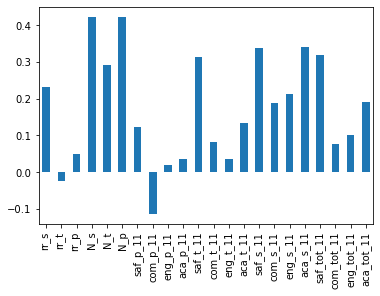

In [16]:
combined.corr()["sat_score"][survey_fields].plot.bar()